In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
!cp '/content/drive/My Drive/traffic-signs-data.zip' '/content/traffic-signs-data.zip'

In [38]:
!unzip /content/traffic-signs-data.zip

Archive:  /content/traffic-signs-data.zip
replace test.p? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test.p                  
  inflating: train.p                 
  inflating: valid.p                 


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import pickle

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
with open('/content/train.p','rb') as f:
  train = pickle.load(f)

with open('/content/valid.p', 'rb') as f:
  eval = pickle.load(f)


In [5]:
X_train, y_train = train['features'],train['labels']
X_eval , y_eval = eval['features'],eval['labels']

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_eval.shape)
print(y_eval.shape)

(34799, 32, 32, 3)
(34799,)
(4410, 32, 32, 3)
(4410,)


41


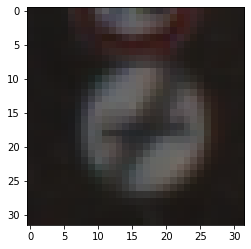

In [7]:
print(y_train[0])
plt.imshow(X_train[0])
plt.show()

In [8]:
n_classes,counts = np.unique(y_train,return_counts=True)
print(n_classes)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


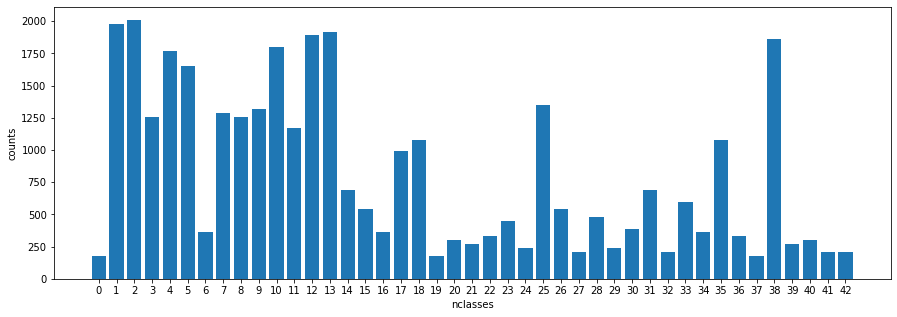

In [9]:
plt.rcParams['figure.figsize']=[15,5]
plt.bar(n_classes,counts,tick_label=n_classes,width=0.8,align='center')
plt.xlabel('nclasses')
plt.ylabel('counts')
plt.show()

In [10]:
import torchvision.transforms as transforms
import random
trans = transforms.Compose([transforms.ToTensor()])

def next_batch(X,y,batch_size,shuffle=True):
  start_index = 0
  arr = np.arange(0,X.shape[0])
  if shuffle==True:
      random.shuffle(arr)


  while start_index < X.shape[0]:
    images = X[arr[start_index:start_index+batch_size],:,:,:]
    images = np.transpose(images,(0,3,1,2))
    images = torch.Tensor(images)
    labels = y[arr[start_index:start_index+batch_size]]
    labels = torch.Tensor(labels)
    # print(type(images))
    # print(images.shape)
    
    yield (images,labels)

    start_index+=batch_size



In [11]:
import torch.nn as nn

class LeNet(nn.Module):

  def __init__(self):
    super(LeNet,self).__init__()

    self.cnn_model = nn.Sequential(
        nn.Conv2d(3,6,5),
        nn.Tanh(),
        nn.AvgPool2d(2,stride=2),
        nn.Conv2d(6,16,5),
        nn.Tanh(),
        nn.AvgPool2d(2,stride=2)
    )

    self.fc_model = nn.Sequential(
        nn.Linear(400,120),
        nn.Tanh(),
        nn.Linear(120,84),
        nn.Tanh(),
        nn.Linear(84,43)
    )

  def forward(self,X):
    X = self.cnn_model(X)
    #X = X.view(X.size(0),-1)
    X = X.reshape(X.size(0),-1)
    X = self.fc_model(X)
    return X

In [12]:
net = LeNet().to(device)
display(net)

LeNet(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=43, bias=True)
  )
)

In [50]:
# u=np.random.rand(16,5,5)
# print(u.shape)
# u = u.reshape(-1)
# print(u.shape)

(16, 5, 5)
(400,)


In [51]:
# def evaluation(X,y,model,batch_size,data_size,data_gen):
#   n_batches = math.ceil(data_size/batch_size)
#   last_batch_size = data_size%batch_size

#   accuracy=[]
  
#   for _ in range(n_batches):
#     images,labels = next(data_gen)
#     output = model(images)
#     _,pred = torch.max(output.data,1)



In [13]:
def calculate_accuracy(data_gen,model,data_size,batch_size):
  tot,corr=0,0
  n_batches = math.ceil(data_size/batch_size)
  last_batch = data_size%batch_size
  for _ in range(n_batches):
    images,labels = next(data_gen)
    images,labels = images.to(device),labels.to(device)
    # images = trans(images)
    # labels = trans(labels)

    output = model(images)
    _,pred = torch.max(output.data,1)
    pred = pred.to(device)
    tot+=labels.size(0)
    corr+=(pred==labels).sum().item()

    del images,labels,pred
  return 100*corr/tot
    


In [14]:
import torch.optim as optim
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

Epoch: 0/15 , Train acc: 92.70, Eval acc: 89.48 
Epoch: 1/15 , Train acc: 96.00, Eval acc: 91.27 
Epoch: 2/15 , Train acc: 96.58, Eval acc: 90.23 
Epoch: 3/15 , Train acc: 96.83, Eval acc: 91.86 
Epoch: 4/15 , Train acc: 98.39, Eval acc: 92.09 
Epoch: 5/15 , Train acc: 98.62, Eval acc: 90.88 
Epoch: 6/15 , Train acc: 99.45, Eval acc: 92.99 
Epoch: 7/15 , Train acc: 98.84, Eval acc: 92.31 
Epoch: 8/15 , Train acc: 99.70, Eval acc: 93.20 
Epoch: 9/15 , Train acc: 99.72, Eval acc: 92.88 
Epoch: 10/15 , Train acc: 99.04, Eval acc: 90.18 
Epoch: 11/15 , Train acc: 99.82, Eval acc: 93.31 
Epoch: 12/15 , Train acc: 96.74, Eval acc: 87.94 
Epoch: 13/15 , Train acc: 99.89, Eval acc: 93.95 
Epoch: 14/15 , Train acc: 99.93, Eval acc: 93.33 


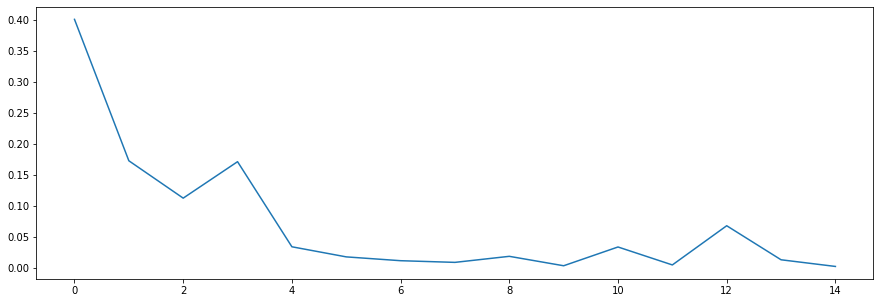

In [15]:
import math
loss_arr=[]
loss_epoch_arr=[]
max_epochs=15
batch_size=64
for epoch in range(max_epochs):
  train_gen = next_batch(X_train,y_train,batch_size,shuffle=True)
  n_batches_train=math.ceil(X_train.shape[0]/batch_size)

  for _ in range(n_batches_train):
    images,labels = next(train_gen)
    images,labels = images.to(device),labels.to(device)
    # images = trans(images)
    # labels = trans(labels)
    opt.zero_grad()
    outputs = net(images)
    outputs = outputs.to(device)  #Dont miss this or else loss will be at 0 all time

    loss = loss_fn(outputs,labels.long())
    loss.backward()
    opt.step()
    loss_arr.append(loss.item())
    del images,labels,outputs

  loss_epoch_arr.append(loss.item())
  with torch.no_grad():  
    train_gen = next_batch(X_train,y_train,batch_size,shuffle=False)
    train_size = X_train.shape[0]
    train_acc = calculate_accuracy(train_gen,net,train_size,batch_size)

    valid_gen = next_batch(X_eval,y_eval,batch_size,shuffle=False)
    valid_size = X_eval.shape[0]
    eval_acc = calculate_accuracy(valid_gen,net,valid_size,batch_size)

  
  print('Epoch: %d/%d , Train acc: %0.2f, Eval acc: %0.2f '%(epoch,max_epochs,train_acc,eval_acc))

plt.plot(loss_epoch_arr)
plt.show()

In [17]:
torch.save(net.state_dict(),'./model.pth')

In [73]:
net = LeNet()
net.load_state_dict(torch.load('./model.pth',map_location=torch.device('cpu')))
net = net.to(device)

In [23]:
with open('/content/test.p','rb') as f:
  test = pickle.load(f)

X_test, y_test = test['features'],test['labels']
print(X_test.shape)
print(y_test.shape)

(12630, 32, 32, 3)
(12630,)


In [77]:
from sklearn import metrics
import seaborn as sns
def confusion_matrix(data_gen,model,data_size,batch_size):
  tot,corr=0,0
  n_batches = math.ceil(data_size/batch_size)
  last_batch = data_size%batch_size
  y=[]
  y_hat=[]
  for _ in range(n_batches):
    images,labels = next(data_gen)
    images,labels = images.to(device),labels.to(device)
    # images = trans(images)
    # labels = trans(labels)

    output = model(images)
    _,pred = torch.max(output.data,1)
    u = pred.clone().detach()
    y_hat.extend(u)
    y.extend(labels)

    cm = metrics.confusion_matrix(y,y_hat)
    pred = pred.to(device)
    tot+=labels.size(0)
    corr+=(pred==labels).sum().item()

    del images,labels,pred

  return 100*corr/tot,cm
    


In [74]:
net.eval()
test_size = X_test.shape[0]
test_gen = next_batch(X_test,y_test,test_size,shuffle=False)
print(calculate_accuracy(test_gen,net,test_size,test_size))

92.20110847189233


92.20110847189233


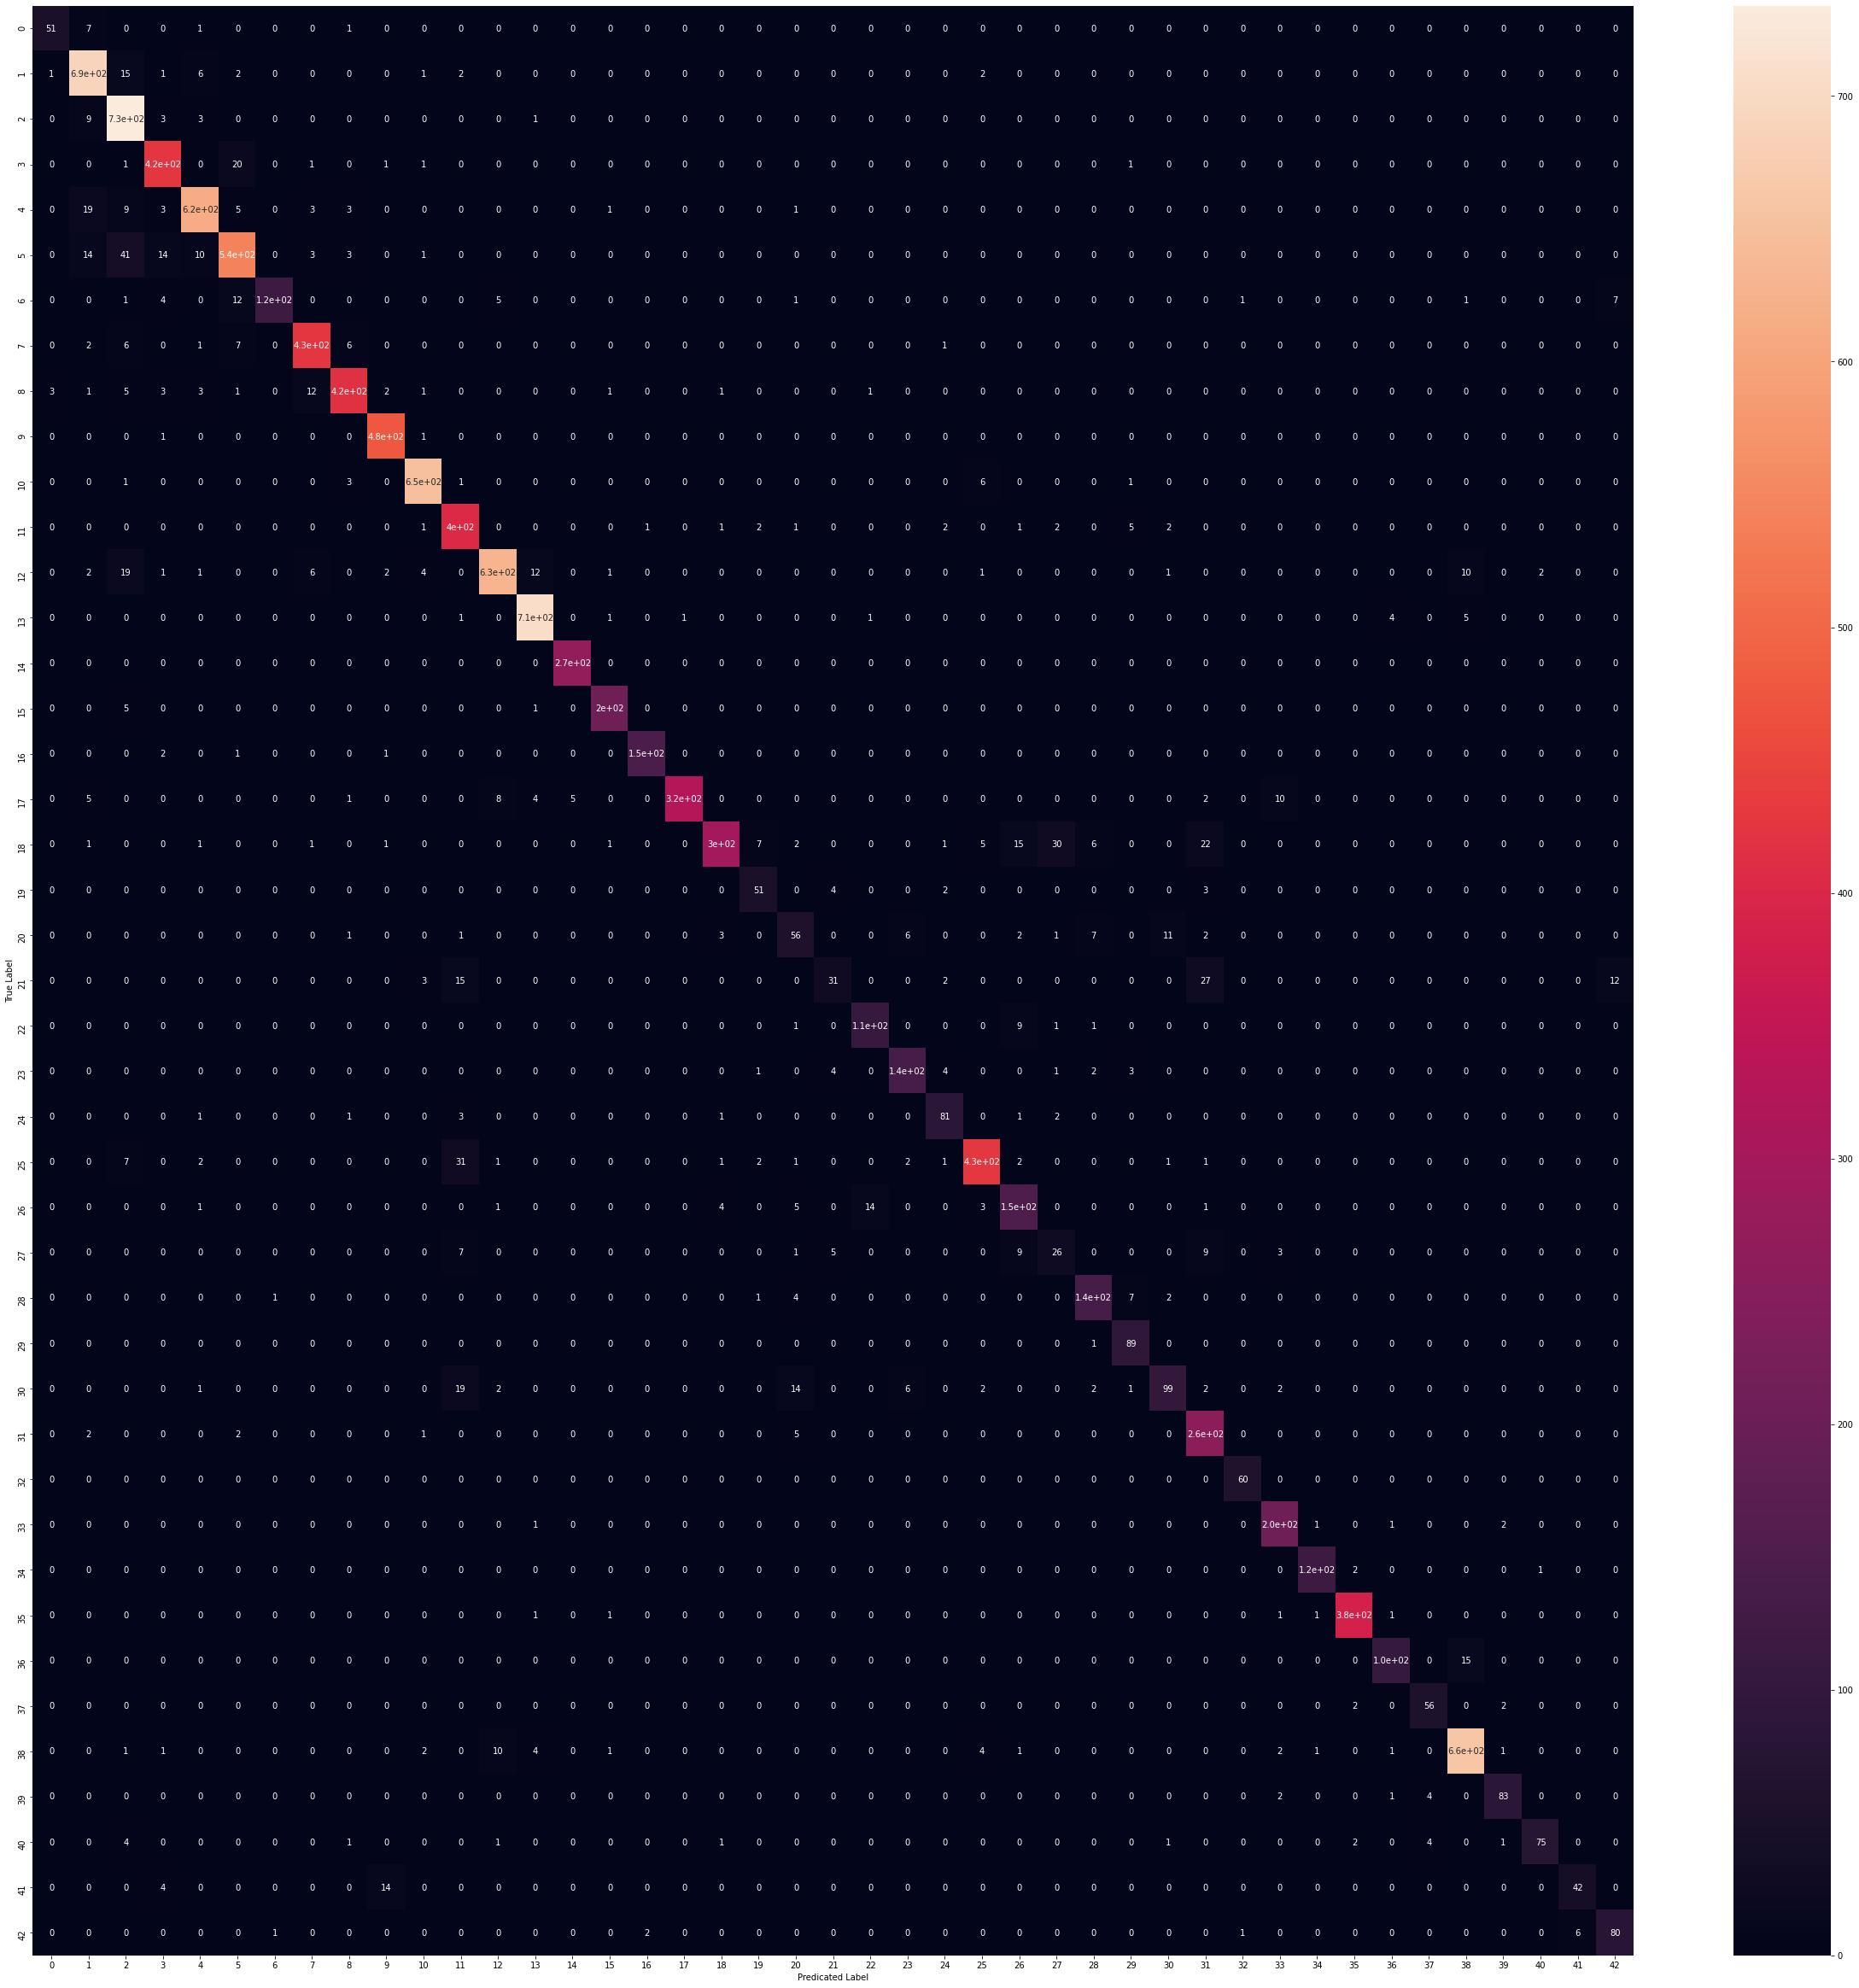

In [89]:
net.eval()
test_size = X_test.shape[0]
test_gen = next_batch(X_test,y_test,test_size,shuffle=False)

acc,cm=confusion_matrix(test_gen,net,test_size,test_size)
print(acc)
plt.figure(figsize = (42,42))

ax=sns.heatmap(cm,annot=True)
ax.set_ylabel('True Label')
ax.set_xlabel('Predicated Label')

plt.savefig('confusion_matrix.png')

38
tensor([38])


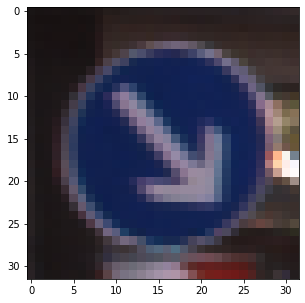

In [23]:
inp = 5
print(y_test[inp])

im = X_test[inp]
im = np.expand_dims(im,axis=0)
im = np.transpose(im,(0,3,1,2))
im = torch.Tensor(im)
im = im.to(device)
out = net(im)
_,pred = torch.max(out.data,1)
print(pred)
plt.imshow(X_test[inp])
plt.show()

In [24]:
display(net)

LeNet(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=43, bias=True)
  )
)

In [56]:
v = net.cnn_model[3].weight.data
print(v.shape)

torch.Size([16, 6, 5, 5])


In [47]:
import seaborn as sns
def plot_filters_single_channel_big(t):
  nrows = t.shape[0]*t.shape[2]
  ncols = t.shape[1]*t.shape[3]

  npimg = np.array(t.numpy(),np.float32)
  npimg = npimg.transpose((0,2,1,3))
  print(npimg.shape)
  npimg = npimg.ravel().reshape(nrows,ncols)
  print(npimg.shape)
  npimg = npimg.T
  print(npimg.shape)

  fig,ax = plt.subplots(figsize = (ncols,nrows))
  imgplot = sns.heatmap(npimg,xticklabels=False,yticklabels=False,cmap='Greys',ax=ax,cbar=False)


In [49]:
def plot_filters_single_channel(t):
  nplots = t.shape[0]*t.shape[1]
  ncols = 6
  nrows = 1 + nplots//ncols

  npimg = np.array(t.numpy(),np.float32)
  count=0
  fig = plt.figure(figsize=(ncols,nrows))
  for i in range(t.shape[0]):
    for j in range(t.shape[1]):
      count+=1
      ax1 = fig.add_subplot(nrows,ncols,count)
      npimg = np.array(t[i,j].numpy(),np.float32)
      ax1.imshow(npimg)
      ax1.set_title(str(i) + ',' + str(j))
      ax1.axis('off')
      ax1.set_xticklabels([])
      ax1.set_yticklabels([])
   
  plt.tight_layout()
  plt.show()


In [59]:
def plot_filters_multi_channel(t):
  num_kernels = t.shape[0]
  num_cols = 6
  num_rows = num_kernels

  fig=plt.figure(figsize=(num_cols,num_rows))

  for i in range(t.shape[0]):
    ax1 = fig.add_subplot(num_rows,num_cols,i+1)

    npimg = np.array(t[i].numpy(),np.float32)
    npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
    npimg = npimg.transpose((1,2,0))
    ax1.imshow(npimg)
    ax1.axis('off')
    ax1.set_title(str(i))
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

  plt.tight_layout()
  plt.show()


In [63]:
def plot_weights(model,layer_num,single_channel=True,collated=False):
  layer = model.cnn_model[layer_num]

  if isinstance(layer,nn.Conv2d):
    weight_tensor = model.cnn_model[layer_num].weight.data
    print(weight_tensor.shape)
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
    else:
      if weight_tensor.shape[1]==3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print('Not possible')
  else:
    print('Can visualize only Conv layers')
  

torch.Size([6, 3, 5, 5])
(6, 5, 3, 5)
(30, 15)
(15, 30)


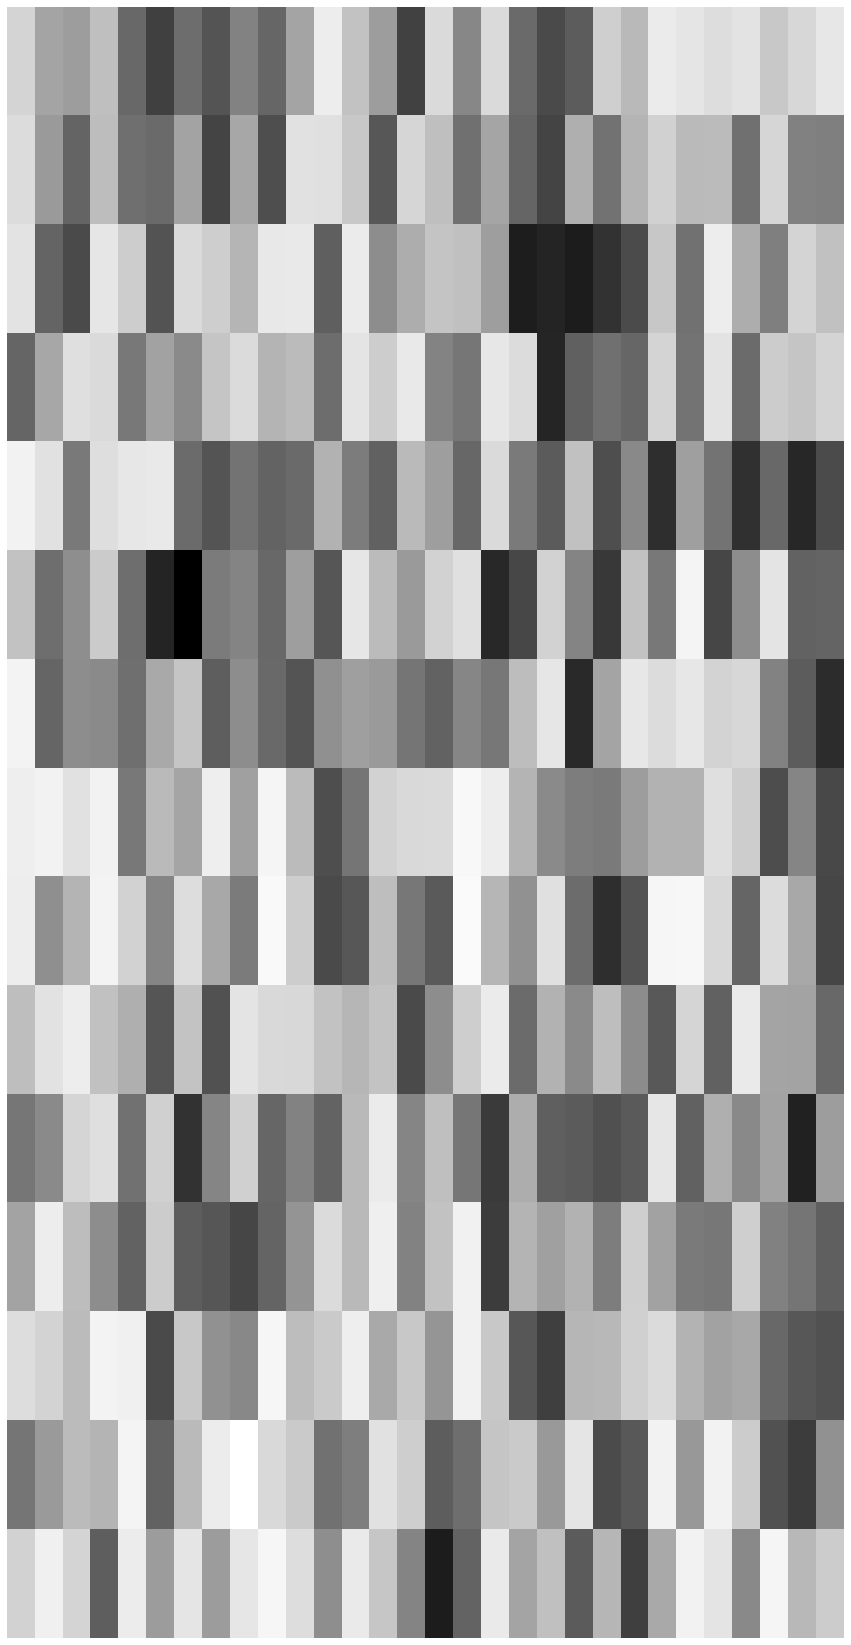

In [48]:
plot_weights(net,0,True,True)

torch.Size([6, 3, 5, 5])


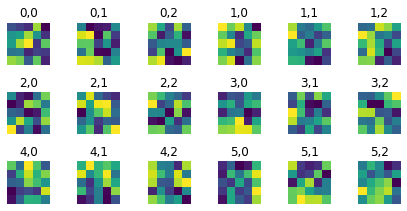

In [51]:
plot_weights(net,0,True,False)

torch.Size([6, 3, 5, 5])


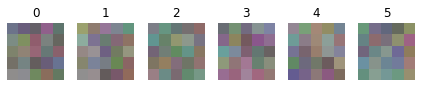

In [60]:
plot_weights(net,0,False,False)

torch.Size([16, 6, 5, 5])


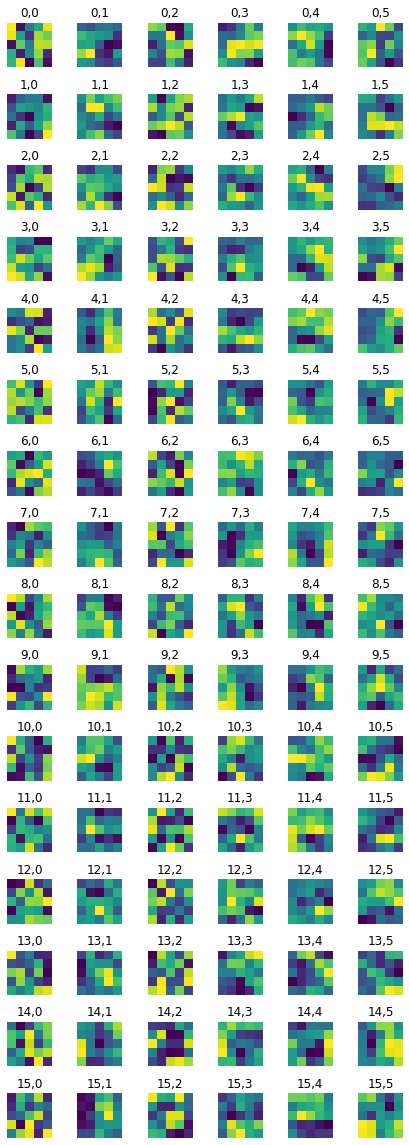

In [64]:
plot_weights(net,3,True,False)

In [ ]:
inp = 5
print(y_test[inp])

im = X_test[inp]
im = np.expand_dims(im,axis=0)
im = np.transpose(im,(0,3,1,2))
im = torch.Tensor(im)
im = im.to(device)
out = net(im)
_,pred = torch.max(out.data,1)
print(pred)
plt.imshow(X_test[inp])
plt.show()